## Assignment 2: $k$ Nearest Neighbor

### Do any four.

## **Q1.** Please answer the following questions.
1. What is the difference between regression and classification?
2. What is a confusion table/matrix? What does it help us understand about a model's performance? 
3. What is Accuracy? Why might it not be entirely sufficient to evaluate a classifer's predictive performance?
4. What does the root mean squared error quantify about a particular model?
5. What are overfitting and underfitting? 
6. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or RMSE on the test set, improve model performance?
7. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.

### **1.1**
Regression: predicts a continuous numeric value (e.g., house price).
Classification: predicts a discrete class/category (e.g., spam vs. not spam), sometimes via class probabilities.

### **1.2** 
A confusion matrix counts how often the model predicts each class vs. the true class (e.g., TP, FP, TN, FN in binary). It helps you see which errors the model makes (false positives vs. false negatives), class-specific performance (precision/recall), and imbalance effects that accuracy can hide.

### **1.3**
Accuracy = (number correct) / (total predictions).

It can be misleading when:

- Classes are imbalanced (predicting the majority class can look “high accuracy”).

- Error types have different costs (FP vs. FN).
  
- You care about per-class performance (accuracy averages everything).
  
- A model can be accurate but poorly calibrated (probabilities not meaningful).


### **1.4**
Root mean squared error measures the typical size of prediction errors in regression. It’s in the same units as the target and penalizes larger errors more (because of squaring).

### **1.5**
Overfitting: model learns noise/specifics of training data → very good train performance, worse test performance (high variance).
Underfitting: model is too simple to capture the pattern → bad train and bad test performance (high bias).

### **1.6**
The split estimates generalization: how the model performs on unseen data.
Tuning k using performance on held-out data helps avoid choosing a k that only fits training quirks.
Net effect: reduces overfitting risk and helps pick a model complexity that generalizes better.

### **1.7**
Class label only (hard prediction)
- Strengths: simple, easy to interpret/use; directly matches many decision tasks.
- Weaknesses: no confidence/uncertainty info; threshold/cost tradeoffs are hidden; can’t easily rank or calibrate decisions.

Probability distribution (soft prediction)
- Strengths: expresses uncertainty; supports thresholding based on costs (e.g., favor recall); enables ranking and metrics like ROC-AUC/log loss; useful for downstream decision-making.
- Weaknesses: probabilities can be miscalibrated; harder to explain to nontechnical audiences; requires choosing thresholds/policies to act on them.

**Q2.** This is a case study on $k$ nearest neighbor classification, using the `land_mines.csv` data.

The data consists of a label, `mine_type`, taking integer values 1 to 5, and three properties of the mine, `voltage`, `height` and `soil`. We want to predict the kind of mine from data about it. Imagine working for the DOD or a humanitarian aid agency, trying to help people remove land mines more safely.

1. Load the data. Perform some EDA, summarizing the target label and the relationships between the features (e.g. scatterplots, describe tables).
2. Split the sample 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be, in my experience: Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion table for your best model, comparing predicted and actual class label on the test set. How accurate is it? Where is performance more or less accurate?
5. Notice that you can have a lot of accurate predictions for a given type of mine, but still make a lot of mistakes. Please explain how you'd advise someone to actually use this predictive model in practice, given the errors that it tends to make.

In [6]:
import urllib.request
import os
import zipfile
import os

def download_data(force=False):
    """Download and extract course data from Zenodo."""
    
    zip_path = 'data.zip'
    data_dir = './data'
    
    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/18235955/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")
    
    if not os.path.exists(data_dir) or force:
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")
    
    return data_dir


if __name__ == "__main__":
    download_data()

In [15]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#2.1

df = pd.read_csv('data/land_mines.csv')
df.head()
df.info()
df.describe()
df["mine_type"].value_counts().sort_index()
df.groupby("mine_type")[["voltage","height","soil"]].describe()
df[["voltage","height","soil"]].corr()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   voltage    338 non-null    float64
 1   height     338 non-null    float64
 2   soil       338 non-null    float64
 3   mine_type  338 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 10.7 KB


,voltage,height,soil
voltage,1.000000,-0.377523,0.070673
height,-0.377523,1.000000,-0.006957
soil,0.070673,-0.006957,1.000000


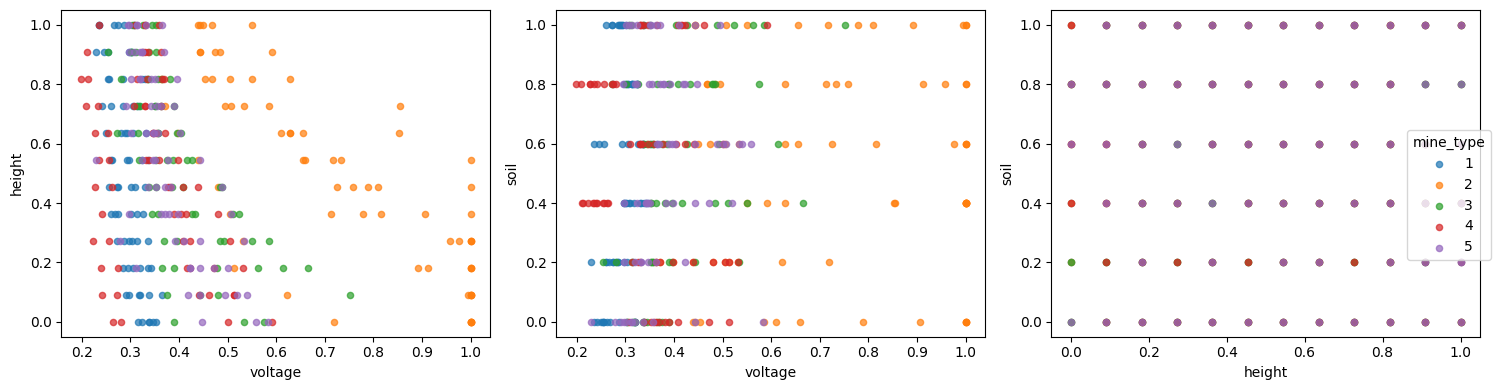

In [ ]:
#2.1
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

pairs = [("voltage","height"), ("voltage","soil"), ("height","soil")]
for ax, (xcol, ycol) in zip(axes, pairs):
    for c in sorted(df["mine_type"].unique()):
        tmp = df[df["mine_type"] == c]
        ax.scatter(tmp[xcol], tmp[ycol], s=20, alpha=0.7, label=str(c))
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="mine_type", loc="center right")
plt.tight_layout()
plt.show()

In [17]:
#2.2
from sklearn.model_selection import train_test_split

X = df[["voltage","height","soil"]]
y = df["mine_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

y_train.value_counts().sort_index(), y_test.value_counts().sort_index()

(mine_type
 1    35
 2    35
 3    33
 4    33
 5    33
 Name: count, dtype: int64,
 mine_type
 1    36
 2    35
 3    33
 4    33
 5    32
 Name: count, dtype: int64)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": list(range(1, 31, 2)),
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]
}

gs = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring="accuracy")
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_

({'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'},
 np.float64(0.47932263814616755))

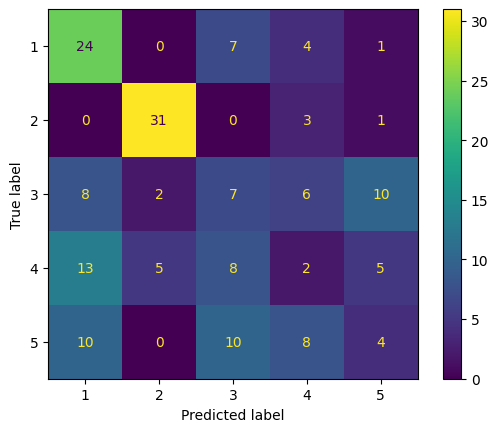

              precision    recall  f1-score   support

           1      0.436     0.667     0.527        36
           2      0.816     0.886     0.849        35
           3      0.219     0.212     0.215        33
           4      0.087     0.061     0.071        33
           5      0.190     0.125     0.151        32

    accuracy                          0.402       169
   macro avg      0.350     0.390     0.363       169
weighted avg      0.358     0.402     0.373       169



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc
labels = sorted(y.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(values_format="d")
plt.show()
print(classification_report(y_test, y_pred, digits=3))


### **2.4 answer:** 
look at which classes have lowest recall (missed true mines of that type) and which off-diagonal cells in the confusion matrix are largest (which types get confused with which) to see where performance is more or less acurate.

### **2.5 Answer**
- Use it as a decision-support tool, not an autopilot: human confirms before action.
- Prefer a probability-based workflow: if the model is low-confidence (e.g., top class prob < 0.6), label as “uncertain—needs extra scan”.
- If the safety cost of missing a dangerous mine type is high, tune for higher recall on that type (even if accuracy drops), and treat predicted “safe” types cautiously.
- Operationally: use predictions to prioritize procedures/equipment and triage (what to examine first), not to skip safety steps.


 ## **Q3.** This question is a case study for $k$ nearest neighbor regression, using the `USA_cars_datasets.csv` data.

The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, `mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.
2. Maxmin normalize `year` and `mileage`.
3. Split the sample into ~80% for training and ~20% for hyper-parameter selection and evaluation.
4. Use the $k$-NN algorithm and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the mean squared error and print a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?
5. Determine the optimal $k$ for these data.
6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

In [37]:
#3.1

df = pd.read_csv('data/USA_cars_datasets.csv')
# keep only needed columns
df = data[["price", "year", "mileage"]].copy()

# look at head
print(df.head())

# dimensions
print("\nShape:", df.shape)

# check NA values
print("\nMissing values per column:")
print(df.isna().sum())

#3.2
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# fit on training data only
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert back to DataFrame (optional but nice for readability)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=["year", "mileage"])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=["year", "mileage"])

print(X_train_scaled.head())




   price  year  mileage
0   6300  2008   274117
1   2899  2011   190552
2   5350  2018    39590
3  25000  2014    64146
4  27700  2018     6654

Shape: (2499, 3)

Missing values per column:
price      0
year       0
mileage    0
dtype: int64
       year   mileage
0  0.389922  0.226640
1  0.596212  0.060636
2  0.143389  0.345924
3  0.208319  0.178926
4  0.755157  0.152087


Train shape: (1999, 2) (1999,)
Test shape:  (500, 2) (500,)


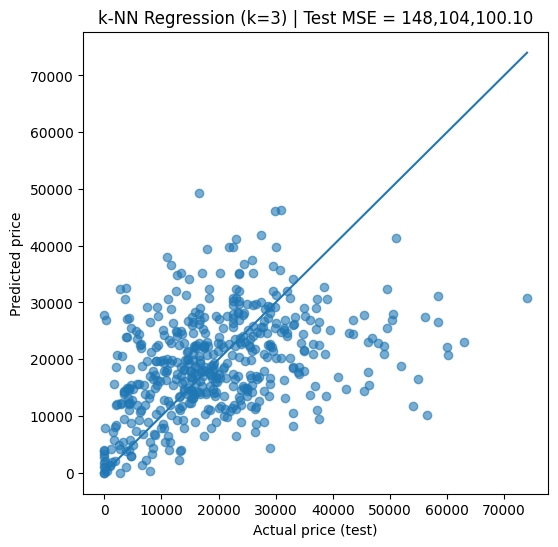

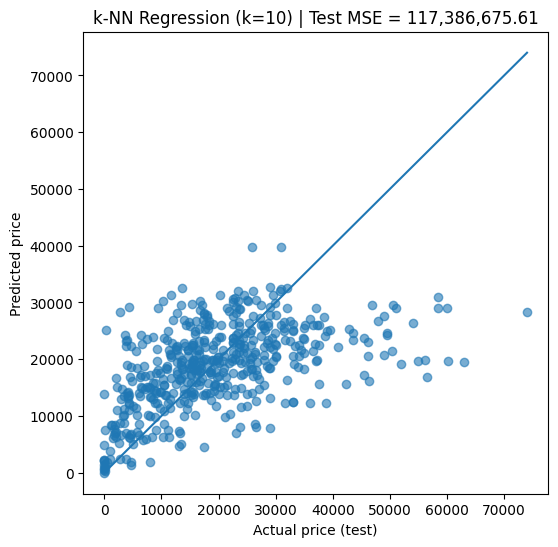

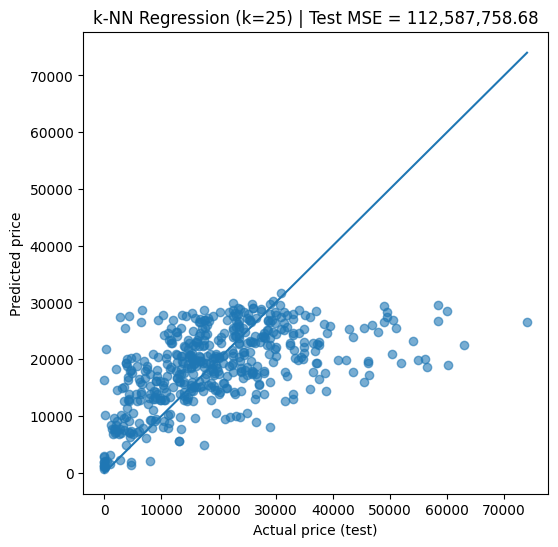

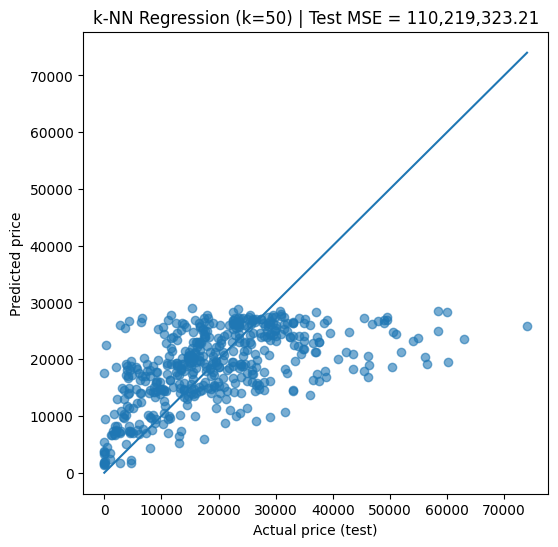

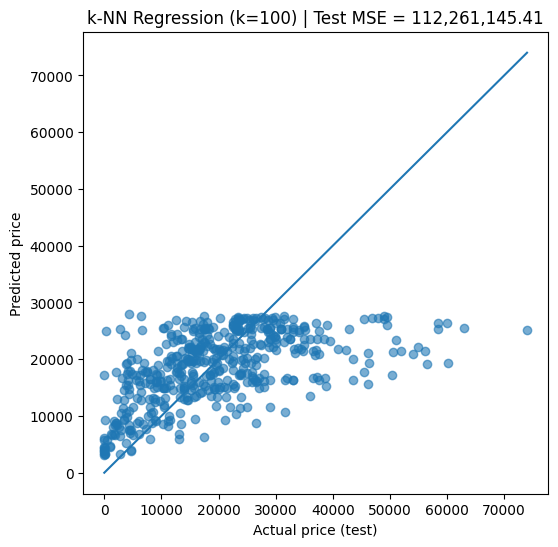

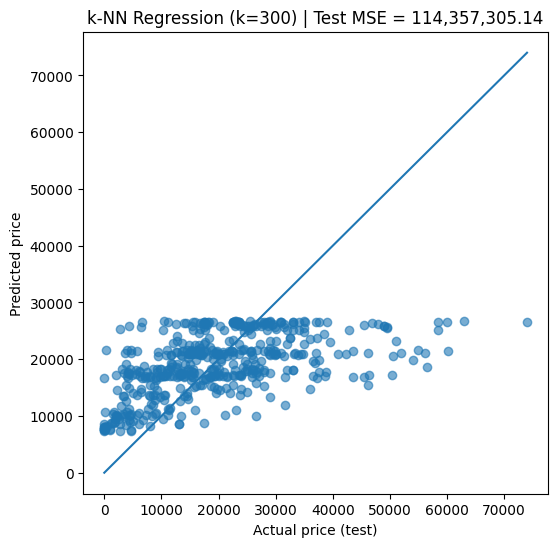

In [41]:
#3.3
from sklearn.model_selection import train_test_split

X = df[["year", "mileage"]]
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape: ", X_test.shape, y_test.shape)

#3.4
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
k_values = [3, 10, 25, 50, 100, 300]
results = []

for k in k_values:
    model = Pipeline([
        ("scaler", MinMaxScaler()),          # scales year + mileage
        ("knn", KNeighborsRegressor(n_neighbors=k))
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results.append((k, mse))
    
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    lo = min(y_test.min(), y_pred.min())
    hi = max(y_test.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi])            # y = x reference line
    plt.xlabel("Actual price (test)")
    plt.ylabel("Predicted price")
    plt.title(f"k-NN Regression (k={k}) | Test MSE = {mse:,.2f}")
    plt.show()


In [42]:
results_df = pd.DataFrame(results, columns=["k", "test_MSE"]).sort_values("test_MSE")
print(results_df)

best_k = int(results_df.iloc[0]["k"])
best_mse = results_df.iloc[0]["test_MSE"]
print(f"\nOptimal k = {best_k} (lowest test MSE = {best_mse:,.2f})")

     k      test_MSE
3   50  1.102193e+08
4  100  1.122611e+08
2   25  1.125878e+08
5  300  1.143573e+08
1   10  1.173867e+08
0    3  1.481041e+08

Optimal k = 50 (lowest test MSE = 110,219,323.21)


### **3.6**
Small k (e.g., 3) gave a wide, noisy scatter around the y=x line because the model was too sensitive to local points -> overfitting.
As k increased to a moderate value (the optimal k), points clustered closer to the y=x line -> best generalization.
Very large k (e.g., 300) made predictions shrink toward the average price, underpredicting high prices and overpredicting low prices -> underfitting.

**Q4.** This question is a case study for $k$ nearest neighbor regression, using the `heart_failure_clinical_records_dataset.csv` data.

The data for the question include:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- death event: if the patient deceased during the follow-up period (boolean)

1. Load the `./data/heart_failure_clinical_records_dataset.csv`. Are there any `NA`'s to handle? use `.drop()` to remove `time` from the dataframe.
2. Make a correlation matrix. What variables are strongly associated with a death event?
3. For the dummy variables `anaemia`, `diabetes`, `high_blood_pressure`, `sex`, and `smoking`, compute a summary table of `DEATH_EVENT` grouped by the variable. For which variables does a higher proportion of the population die when the variable takes the value 1 rather than 0?
4. On the basis of your answers from 2 and 3, build a matrix $X$ of the variables you think are most predictive of a death, and a variable $y$ equal to `DEATH_EVENT`.
5. Maxmin normalize all of the variables in `X`.
6. Split the sample into ~80% for training and ~20% for evaluation. (Try to use the same train/test split for the whole question, so that you're comparing apples to apples in the questions below.).
7. Determine the optimal number of neighbors for a $k$-NN classification or regression for the variables you selected.
8. OK, do steps 5 through 7 again, but use all of the variables (except `time`). Which model has the best Mean Squared Error? Which would you prefer to use in practice, if you had to predict `DEATH_EVENT`s? If you play with the selection of variables, how much does the RMSE change for your fitted model on the test data? Are more variables always better? Explain your findings.

**Q5.** This is a case study on $k$ nearest neighbor classification, using the `animals.csv` data.

The data consist of a label, `class`, taking integer values 1 to 7, the name of the species, `animal`, and 16 characteristics of the animal, including `hair`, `feathers`, `milk`, `eggs`, `airborne`, and so on. 

1. Load the data. For each of the seven class labels, print the values in the class and get a sense of what is included in that group. Perform some other EDA: How big are the classes? How much variation is there in each of the features/covariates? Which variables do you think will best predict which class?
2. Split the data 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be. Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)
3. Using all of the variables, build a $k$-NN classifier. Explain how you select $k$.
4. Print a confusion matrix for the optimal model, comparing predicted and actual class label on the test set. How accurate it is? Can you interpret why mistakes are made across groups?
5. Use only `milk`, `aquatic`, and `airborne` to train a new $k$-NN classifier. Print your confusion table. Mine does not predict all of the classes, only a subset of them. To see the underlying proportions/probabilities, use `model.predict_proba(X_test.values)` to predict probabilities rather than labels for your `X_test` test data for your fitted `model`. Are all of the classes represented? Explain your results.

## **Q6.** This is a case study using $k$ nearest neighbor regression for imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to column filter the dataframe to those variables.
2. Set use `.isnull()` and `.loc` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.
3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.
4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)
5. Predict the missing ratings. 
6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Describe what you see.

In [49]:
#6.1
df = pd.read_csv('data/airbnb_hw.csv')
# Keep only the specified columns using .loc
df = df.loc[:, ["Review Scores Rating", "Price", "Beds"]]

# Look at the first few rows
print(df.head())

# Check dimensions
print("Shape:", df.shape)

#6.2
# Select rows with missing Review Scores Rating
missing_reviews = df.loc[df["Review Scores Rating"].isnull()]

# Keep the remaining (non-missing) rows for modeling
df_clean = df.loc[~df["Review Scores Rating"].isnull()]
df["Price"] = df["Price"].str.replace(",", "").astype(float)

print("Missing review rows:", missing_reviews.shape)
print("Clean rows:", df_clean.shape)

#6.3
df = df.dropna(axis=0, how='any')

print("Shape after dropping NA rows:", df.shape)
print(df.isnull().sum())

   Review Scores Rating Price  Beds
0                   NaN   145   1.0
1                   NaN    37   1.0
2                   NaN    28   1.0
3                   NaN   199   3.0
4                  96.0   549   3.0
Shape: (30478, 3)
Missing review rows: (8323, 3)
Clean rows: (22155, 3)
Shape after dropping NA rows: (22111, 3)
Review Scores Rating    0
Price                   0
Beds                    0
dtype: int64


In [51]:
#6.4
X = df[["Price", "Beds"]]
y = df["Review Scores Rating"]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# try a range of k values and pick the one with smallest SSE on test
k_values = list(range(1, 51))  # "reasonable" range; you can widen if you want
sse_list = []

for k in k_values:
    model = Pipeline([
        ("scaler", MinMaxScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=k))
    ])
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    sse = np.sum((y_test - preds) ** 2)
    sse_list.append(sse)

results = pd.DataFrame({"k": k_values, "SSE_test": sse_list})
best_row = results.loc[results["SSE_test"].idxmin()]
best_k = int(best_row["k"])

print(results.sort_values("SSE_test").head(10))
print(f"\nChosen k = {best_k} (min test SSE = {best_row['SSE_test']:.2f})")

#6.5
X_train_full = df[["Price", "Beds"]]
y_train_full = df["Review Scores Rating"]

# rows we set aside earlier with missing ratings
to_pred = missing_reviews.copy()

# make sure types are numeric (same cleaning)
to_pred["Price"] = to_pred["Price"].astype(str).str.replace("$", "", regex=False).str.replace(",", "", regex=False).astype(float)
to_pred["Beds"] = pd.to_numeric(to_pred["Beds"], errors="coerce")

# drop any rows that still have NA in predictors
to_pred = to_pred.dropna(subset=["Price", "Beds"])

# fit final model using the chosen k (replace best_k with your selected k)
best_k = best_k  # if you already computed it above
model = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=best_k))
])
model.fit(X_train_full, y_train_full)

# predict missing ratings
to_pred["Predicted Review Scores Rating"] = model.predict(to_pred[["Price", "Beds"]])

to_pred[["Price", "Beds", "Predicted Review Scores Rating"]].head()

     k       SSE_test
45  46  321221.901701
46  47  321315.025351
44  45  321367.409383
37  38  321458.760388
49  50  321478.910400
48  49  321527.893378
38  39  321714.133465
40  41  321739.939322
47  48  321817.489583
42  43  321928.327204

Chosen k = 46 (min test SSE = 321221.90)


,Price,Beds,Predicted Review Scores Rating
0,145.0,1.0,94.369565
1,37.0,1.0,89.521739
2,28.0,1.0,84.913043
3,199.0,3.0,88.913043
13,68.0,1.0,91.934783


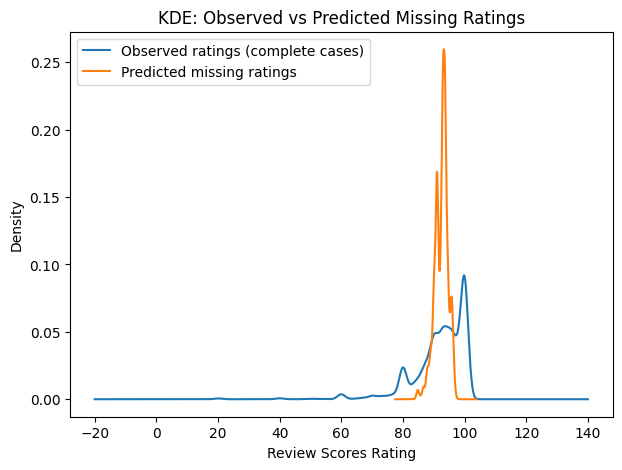

In [52]:
#6.6
plt.figure(figsize=(7,5))
df["Review Scores Rating"].plot(kind="kde", label="Observed ratings (complete cases)")
to_pred["Predicted Review Scores Rating"].plot(kind="kde", label="Predicted missing ratings")
plt.xlabel("Review Scores Rating")
plt.title("KDE: Observed vs Predicted Missing Ratings")
plt.legend()
plt.show()

### **6.6 Answer:**
 The predicted missing ratings (orange) are much more concentrated and sharply peaked around roughly 90–95, while the observed ratings (blue) are more spread out and show a wider range. This suggests the k-NN model is shrinking predictions toward the mean, producing less variability than the true ratings. In other words, the predicted ratings look smoother and less extreme, indicating some underfitting and regression toward the average.

**Q7.** Let's do some very basic computer vision. We're going to import the MNIST handwritten digits data and use $k$-NN to predict values (i.e. "see/read").

1. To load the data, run the following code in a chunk:
```
from keras.datasets import mnist
df = mnist.load_data('minst.db')
train,test = df
X_train, y_train = train
X_test, y_test = test
```
The `y_test` and `y_train` vectors, for each index `i`, tell you want number is written in the corresponding index in `X_train[i]` and `X_test[i]`. The value of `X_train[i]` and `X_test[i]`, however, is a 28$\times$28 array whose entries contain values between 0 and 256. Each element of the matrix is essentially a "pixel" and the matrix encodes a representation of a number. To visualize this, run the following code to see the first ten numbers:
```
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
for i in range(5): 
    print(y_test[i],'\n') # Print the label
    print(X_test[i],'\n') # Print the matrix of values
    plt.contourf(np.rot90(X_test[i].transpose())) # Make a contour plot of the matrix values
    plt.show()
```
OK, those are the data: Labels attached to handwritten digits encoded as a matrix.

2. What is the shape of `X_train` and `X_test`? What is the shape of `X_train[i]` and `X_test[i]` for each index `i`? What is the shape of `y_train` and `y_test`?
3. Use Numpy's `.reshape()` method to covert the training and testing data from a list of matrix into an vector of features. So, `X_test[index].reshape((1,784))` will convert the $index$-th element of `X_test` into a $28\times 28=784$-length row vector of values, rather than a matrix. Turn `X_train` into an $N \times 784$ matrix $X$ that is suitable for scikit-learn's kNN classifier where $N$ is the number of observations and $784=28*28$ (you could use, for example, a `for` loop).
4. Use the reshaped `X_test` and `y_test` data to create a $k$-nearest neighbor classifier of digit. What is the optimal number of neighbors $k$? If you can't determine this, play around with different values of $k$ for your classifier.
5. For the optimal number of neighbors, how well does your predictor perform on the test set? Report the accuracy, compute a confusion matrix, and explain your findings.
6. For your confusion matrix, which mistakes are most likely? Do you find any interesting patterns?
7. So, this is how computers "see." They convert an image into a matrix of values, that matrix becomes a vector in a dataset, and then we deploy ML tools on it as if it was any other kind of tabular data. To make sure you follow this, invent a way to represent a color photo in matrix form, and then describe how you could convert it into tabular data. (Hint: RGB color codes provide a method of encoding a numeric value that represents a color.)